In [31]:
import sys
from pathlib import Path
BASE_DIR = Path.cwd().parent
sys.path.append(str(BASE_DIR / "src"))
import numpy as np
import pandas as pd

from ict_utils import (read_aps, read_nmass, read_pops, read_uhsas, read_fims, read_inlet_flag,
    check_common_grid, filter_by_spectra_presence, mean_spectrum,)
from sizedist_utils import (edges_from_mids_geometric, dvdlog_from_dndlog, 
    dsdlog_from_dndlog, mids_from_edges, remap_dndlog_by_edges, select_between)

# ============================ CONFIG ============================
start = "2024-06-11 16:00"                                              # Change this
end   = "2024-06-11 16:10"                                              # Change this

# start = "2024-08-02 15:00"                                              # Change this
# end   = "2024-08-02 15:10"                                              # Change this

start = "2024-06-07 15:55"                                              # Change this
end   = "2024-06-07 16:05"                                              # Change this

# start = "2024-08-08 16:10"                                              # Change this
# end   = "2024-08-08 16:20"                                              # Change this

d_str = pd.to_datetime(start).date().isoformat()
start_time_str = pd.to_datetime(start).time().isoformat()
end_time_str = pd.to_datetime(end).time().isoformat()


DATA_DIR = Path("/Volumes/Hailstone Data/Research Data/ARCSIX_P3B")     # Change this

aps_dir   = DATA_DIR / "LARGE-APS"
nmass_dir = DATA_DIR / "PUTLS-NMASS"
pops_dir  = DATA_DIR / "PUTLS-POPS"
uhsas_dir = DATA_DIR / "PUTLS-UHSAS"
fims_dir  = DATA_DIR / "FIMS"
inlet_dir = DATA_DIR / "LARGE-InletFlag"

OPC_RESPONSE_BINS = 50        # Controls the smoothness of the OPC response functions


# ---------- helpers ----------
def edges_from_meta_or_mids(df: pd.DataFrame, mids_nm: np.ndarray) -> np.ndarray:
    meta = (df.attrs.get("bin_meta") or {})
    lo = meta.get("lower_nm")
    up = meta.get("upper_nm")
    if isinstance(lo, (list, tuple)) and isinstance(up, (list, tuple)) and len(lo) == len(up) and len(lo) > 0:
        return np.r_[np.asarray(lo, float), float(up[-1])]
    return edges_from_mids_geometric(mids_nm)

# ---------- read ----------
aps        = read_aps       (aps_dir,   start=start, end=end, prefix="ARCSIX")
nmass      = read_nmass     (nmass_dir, start=start, end=end, prefix="ARCSIX")
pops       = read_pops      (pops_dir,  start=start, end=end, prefix="ARCSIX")
uhsas      = read_uhsas     (uhsas_dir, start=start, end=end, prefix="ARCSIX")
fims       = read_fims      (fims_dir,  start=start, end=end, prefix="ARCSIX")
inlet_flag = read_inlet_flag(inlet_dir, start=start, end=end, prefix="ARCSIX")

frames = {"APS": aps, "POPS": pops, "UHSAS": uhsas, "FIMS": fims}
_ = check_common_grid(frames, ref_key="FIMS", round_to=None)

# ---------- optional presence filter ----------
fims_qc = pd.to_numeric(fims.get("QC_Flag", pd.Series(index=fims.index)), errors="coerce")
extra = {"FIMS": fims_qc.ne(2)}  # bad=2
filtered, _keep = filter_by_spectra_presence(
    frames, col_prefix="dNdlogDp",
    min_instruments=None,
    extra_masks=extra, treat_nonpositive_as_nan=False
)

def print_bin_table_horizontal(name, mids, n_vals):
    print(f"\n[{name}] Bin summary (horizontal)")
    idx_str = [f"{i:d}" for i in range(len(mids))]
    mid_str = [f"{m:.3f}" for m in mids]
    n_str   = [f"{int(n)}" for n in n_vals]

    def row(label, arr):
        print(f"{label:>8} | " + " ".join(f"{s:>8}" for s in arr))

    row("idx", idx_str)
    row("mid_nm", mid_str)
    row("n", n_str)

print('Calculate bin average numbers:')

frames = filtered # use filtered

# ---------- mean spectra + edges FILTERED ----------
m_APS,   y_APS,   s_APS,   _, n_vals_APS = mean_spectrum(frames['APS'],   "APS")
e_APS = edges_from_meta_or_mids(aps, m_APS)
print_bin_table_horizontal("APS", m_APS, n_vals_APS)

m_POPS,  y_POPS,  s_POPS,  _, n_vals_POPS = mean_spectrum(frames['POPS'],  "POPS")
e_POPS = edges_from_meta_or_mids(pops, m_POPS)
print_bin_table_horizontal("POPS", m_POPS, n_vals_POPS)

m_UHSAS, y_UHSAS, s_UHSAS, _, n_vals_UHSAS = mean_spectrum(frames['UHSAS'], "UHSAS")
e_UHSAS = edges_from_meta_or_mids(uhsas, m_UHSAS)
print_bin_table_horizontal("UHSAS", m_UHSAS, n_vals_UHSAS)

m_FIMS,  y_FIMS,  s_FIMS,  _, n_vals_FIMS = mean_spectrum(frames['FIMS'], "FIMS")
e_FIMS = edges_from_meta_or_mids(fims, m_FIMS)
print_bin_table_horizontal("FIMS", m_FIMS, n_vals_FIMS)



Calculate bin average numbers:

[APS] Bin summary (horizontal)
     idx |        0        1        2        3        4        5        6        7        8        9       10       11       12
  mid_nm |  562.000  631.000  708.000  794.000  891.000 1000.000 1259.000 1585.000 1995.000 2512.000 3162.000 3981.000 5012.000
       n |      472      472      472      472      472      472      472      472      472      472      472      472      472

[POPS] Bin summary (horizontal)
     idx |        0        1        2        3        4        5        6        7        8        9       10       11       12       13       14       15
  mid_nm |  133.700  171.200  215.600  267.900  329.800  402.700  488.900  590.600  710.600  852.300 1020.000 1217.000 1450.000 1725.000 2050.000 2434.000
       n |        0      472      472      472      472      472      472      472      472      472      472      472      472      472      472      472

[UHSAS] Bin summary (horizontal)
     idx |        0  

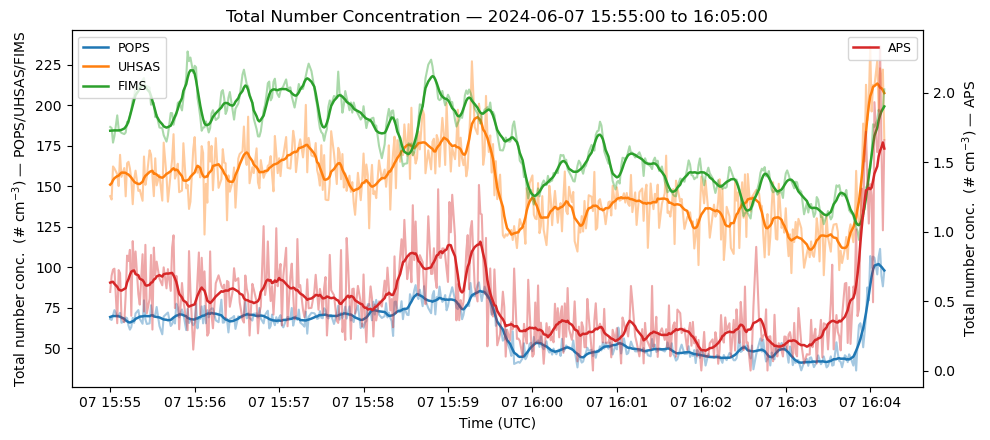

In [40]:
# --- Total concentration time series (APS on secondary y-axis; Gaussian smoothed) ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ict_utils import get_spectra
from sizedist_utils import edges_from_mids_geometric, delta_log10_from_edges

# ===== toggle here =====
USE_FILTERED_FOR_PLOT = True   # set True to plot "filtered", False to plot raw "frames"
PLOT_SOURCE = filtered if USE_FILTERED_FOR_PLOT else frames

# Per-instrument size limits (Dp in nm). Omit key or set to None to disable a bound.
MIN_DIAM_NM = {
    # "FIMS": 100.0,   # e.g., only use FIMS >= 100 nm
    # "POPS": None,
    # "UHSAS": None,
    # "APS": None,
}
MAX_DIAM_NM = {
    # "FIMS": 1000.0,  # example: cap FIMS at 1000 nm
    # "POPS": None,
    # "UHSAS": None,
    # "APS": None,
}
# =======================

GAUSS_WIN_SAMPLES = 10   # total window length (number of points)
GAUSS_STD_SAMPLES = 3    # Gaussian std dev (number of points)

# compute totals from the chosen dict `PLOT_SOURCE` (keys like "APS","POPS","UHSAS","FIMS")
totals = {}
smoothed_totals = {}       # <--- stored here for the next block
plot_labels = {}

for name in ("POPS", "UHSAS", "FIMS", "APS"):
    df = PLOT_SOURCE.get(name)
    if df is None or df.empty:
        continue

    mids_nm, spec_wide = get_spectra(df, col_prefix="dNdlogDp", long=False)
    if spec_wide.empty or mids_nm.size == 0:
        continue

    # --- optional lower/upper size cutoffs per instrument ---
    dmin = MIN_DIAM_NM.get(name, None)
    dmax = MAX_DIAM_NM.get(name, None)

    if (dmin is not None) or (dmax is not None):
        lo_ok = mids_nm >= (float(dmin) if dmin is not None else -np.inf)
        hi_ok = mids_nm <= (float(dmax) if dmax is not None else  np.inf)
        mask = lo_ok & hi_ok
        if not np.any(mask):
            continue  # nothing to plot for this instrument

        # enforce contiguous slice [i0:i1] (true for simple bounds)
        i0 = int(np.argmax(mask))
        i1 = int(len(mids_nm) - np.argmax(mask[::-1]) - 1)
        mids_nm = mids_nm[i0:i1+1]
        spec_wide = spec_wide.iloc[:, i0:i1+1]
    else:
        i0 = 0
        i1 = len(mids_nm) - 1

    # --- choose edges (prefer header, fall back to geometric), then slice to match ---
    meta = (getattr(df, "attrs", {}) or {}).get("bin_meta") or {}
    lo = np.asarray(meta.get("lower_nm", []), dtype=float)
    up = np.asarray(meta.get("upper_nm", []), dtype=float)
    if lo.size and up.size and lo.size == up.size:
        full_edges = np.r_[lo, up[-1]]
        edges_nm = full_edges[i0:i1 + 2]  # +2 because edges are one longer than mids
    else:
        edges_nm = edges_from_mids_geometric(mids_nm)

    if edges_nm.size != mids_nm.size + 1:
        edges_nm = edges_from_mids_geometric(mids_nm)

    # --- integrate ONLY within the selected range (matches the sliced mids/edges) ---
    dlog10 = delta_log10_from_edges(edges_nm)
    A = np.where(np.isfinite(spec_wide.to_numpy(float)), spec_wide.to_numpy(float), 0.0)
    N = (A * dlog10[None, :]).sum(axis=1)

    # store raw totals as a Series
    s_raw = pd.Series(N, index=spec_wide.index, name=name)
    totals[name] = s_raw

    # store Gaussian-smoothed totals for next block
    s_gauss = s_raw.rolling(GAUSS_WIN_SAMPLES, win_type="gaussian",
                            min_periods=1, center=True).mean(std=GAUSS_STD_SAMPLES)
    smoothed_totals[name] = s_gauss

    # label suffix reflecting size choice
    rng = []
    if dmin is not None and dmax is not None:
        rng.append(f"{int(dmin)}–{int(dmax)} nm")
    elif dmin is not None:
        rng.append(f"≥{int(dmin)} nm")
    elif dmax is not None:
        rng.append(f"≤{int(dmax)} nm")
    plot_labels[name] = f"{name} (Dp {rng[0]})" if rng else name

# plot: APS on right axis; others on left; distinct colors (tab10)
fig, ax = plt.subplots(figsize=(10, 4.5))
ax2 = ax.twinx()

order = [k for k in ("POPS", "UHSAS", "FIMS", "APS") if k in totals]
tab = list(plt.cm.tab10.colors)
color_map = {k: tab[i % len(tab)] for i, k in enumerate(order)}

for k in order:
    s_raw = totals[k]
    s_gauss = smoothed_totals[k]

    label = plot_labels.get(k, k)
    if k == "APS":
        ax2.plot(s_raw.index, s_raw.values, color=color_map[k], alpha=0.4, linewidth=1.5)
        ax2.plot(s_gauss.index, s_gauss.values, color=color_map[k], alpha=1.0, linewidth=1.8, label=label)
    else:
        ax.plot(s_raw.index, s_raw.values, color=color_map[k], alpha=0.4, linewidth=1.5)
        ax.plot(s_gauss.index, s_gauss.values, color=color_map[k], alpha=1.0, linewidth=1.8, label=label)

ax.set_xlabel("Time (UTC)")
ax.set_ylabel(r"Total number conc.  (# cm$^{-3}$) — POPS/UHSAS/FIMS")
if "APS" in totals:
    ax2.set_ylabel(r"Total number conc.  (# cm$^{-3}$) — APS")

try:
    ax.set_title(f"Total Number Concentration — {d_str} {start_time_str} to {end_time_str}")
except NameError:
    ax.set_title("Total Number Concentration")

ax.legend(loc="upper left", fontsize=9)
ax2.legend(loc="upper right", fontsize=9)

fig.tight_layout()
plt.show()

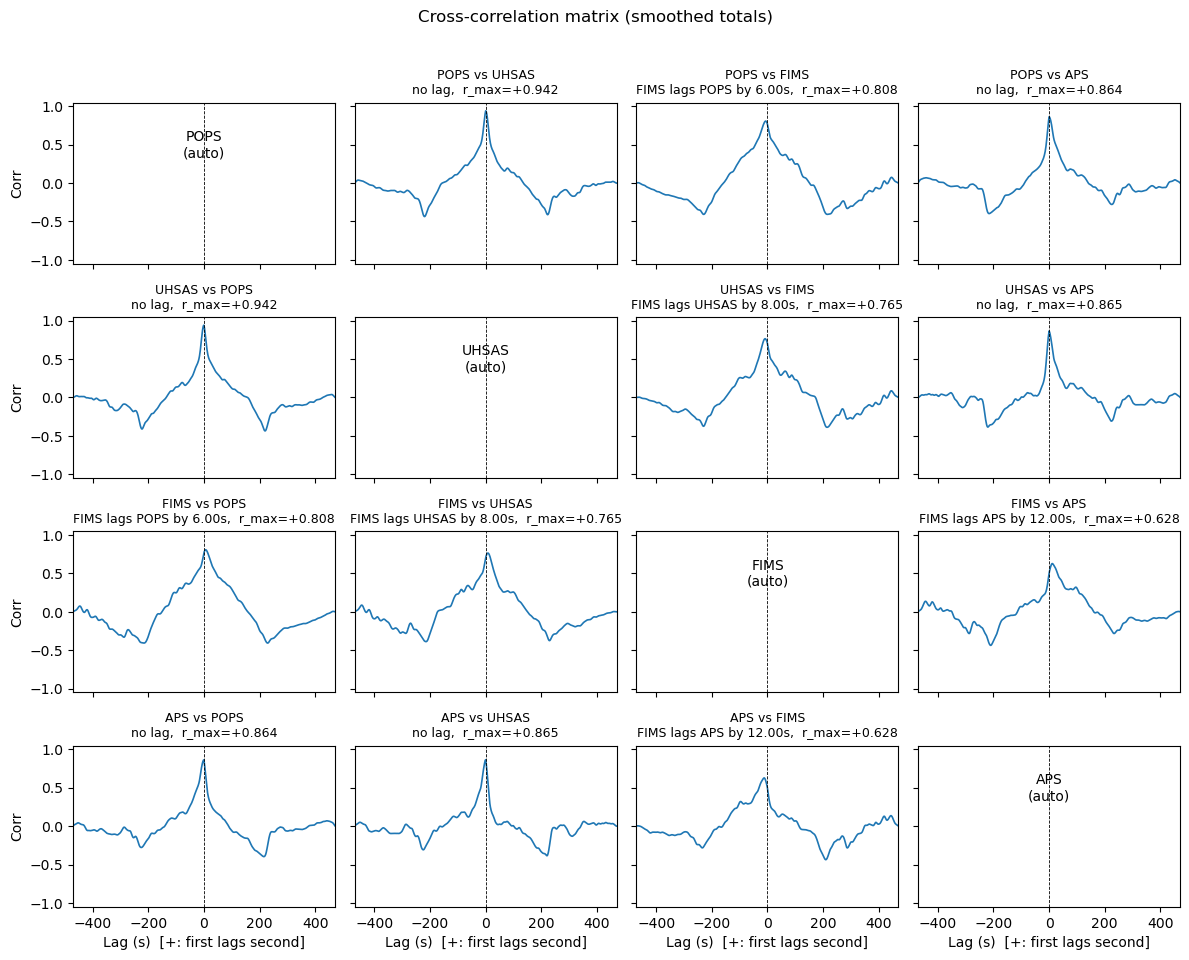

In [37]:
# --- Cross-correlation matrix (4x4 grid) — correct lag phrasing ---
from scipy.signal import correlate

names = ["POPS", "UHSAS", "FIMS", "APS"]
names = [n for n in names if n in smoothed_totals]
k = len(names)

# time step (s)
idx0 = smoothed_totals[names[0]].index
dt = np.median(np.diff(idx0.values).astype("timedelta64[ms]").astype(float)) / 1000.0

def ccf(x, y, dt):
    mask = np.isfinite(x) & np.isfinite(y)
    if not np.any(mask):
        return np.array([0.0]), np.array([0.0]), np.nan, np.nan
    x = x[mask] - np.nanmean(x[mask])
    y = y[mask] - np.nanmean(y[mask])
    if len(x) == 0 or len(y) == 0:
        return np.array([0.0]), np.array([0.0]), np.nan, np.nan
    corr = correlate(x, y, mode="full")
    lags = np.arange(-len(x) + 1, len(x)) * dt
    corr = corr / np.sqrt(np.sum(x ** 2) * np.sum(y ** 2))
    imax = int(np.argmax(corr))
    return lags, corr, lags[imax], corr[imax]

series = {n: smoothed_totals[n].to_numpy() for n in names}

fig, axes = plt.subplots(k, k, figsize=(3.0*k, 2.4*k), sharex=True, sharey=True)

max_lag = None
cache = {}
for i, a in enumerate(names):
    for j, b in enumerate(names):
        if i == j:
            cache[(i, j)] = None
        else:
            lags, corr, lag_max, r_max = ccf(series[a], series[b], dt)
            cache[(i, j)] = (lags, corr, lag_max, r_max)
            max_lag = np.max(np.abs(lags)) if max_lag is None else max(max_lag, np.max(np.abs(lags)))

for i, a in enumerate(names):
    for j, b in enumerate(names):
        ax = axes[i, j] if k > 1 else axes
        if i == j:
            ax.text(0.5, 0.5, f"{a}\n(auto)", ha="center", va="center", fontsize=10)
            ax.axvline(0, color="k", linestyle="--", linewidth=0.6)
        else:
            lags, corr, lag_max, r_max = cache[(i, j)]
            ax.plot(lags, corr, linewidth=1.2)
            ax.axvline(0, color="k", linestyle="--", linewidth=0.6)

            # Correct interpretation:
            # correlate(x=a, y=b): lag > 0  => a lags b;  lag < 0 => b lags a
            if np.isfinite(r_max) and np.isfinite(lag_max):
                if lag_max > 0:
                    phr = f"{a} lags {b} by {lag_max:.2f}s"
                elif lag_max < 0:
                    phr = f"{b} lags {a} by {abs(lag_max):.2f}s"
                else:
                    phr = "no lag"
                ttl = f"{a} vs {b}\n{phr},  r_max={r_max:+.3f}"
            else:
                ttl = f"{a} vs {b}\n(no valid overlap)"
            ax.set_title(ttl, fontsize=9)

        if i == k - 1:
            ax.set_xlabel("Lag (s)  [+: first lags second]")
        if j == 0:
            ax.set_ylabel("Corr")

if max_lag is not None and np.isfinite(max_lag):
    for ax in (axes.ravel() if k > 1 else [axes]):
        ax.set_xlim(-max_lag, +max_lag)
        ax.set_ylim(-1.05, 1.05)

fig.suptitle("Cross-correlation matrix (smoothed totals)", y=0.995)
fig.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

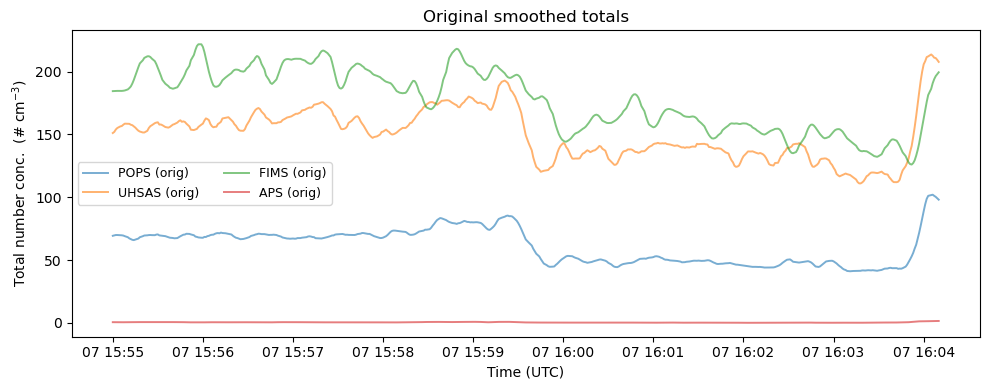

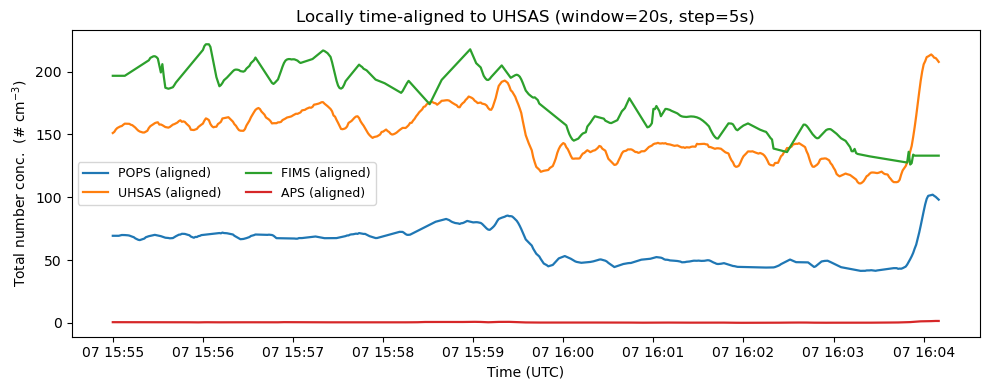

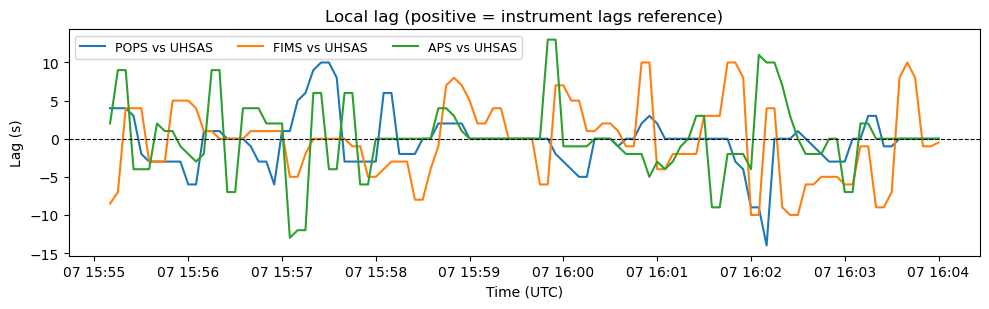

In [42]:
# --- Time-dependent lag/lead + local time-warp alignment (uses smoothed_totals) ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import correlate

# ==== inputs ====
SRC = smoothed_totals          # use the already-saved smoothed totals
names = ["POPS", "UHSAS", "FIMS", "APS"]
names = [n for n in names if n in SRC and not SRC[n].empty]
REF_NAME = "UHSAS" if "UHSAS" in names else names[0]

# window/step length in seconds for local lag estimation
WIN_S = 20.0       # analysis window length (s)
STEP_S = 5.0       # hop size (s)
MAX_LAG_S = 15.0   # clamp allowable lag (s) to avoid spurious matches

# common plotting labels (optional)
labels = {n: plot_labels.get(n, n) if "plot_labels" in globals() else n for n in names}

# ==== helpers ====
def median_dt_seconds(index: pd.DatetimeIndex) -> float:
    dt = np.median(np.diff(index.values).astype("timedelta64[ms]").astype(float)) / 1000.0
    return float(dt)

def xcorr_lag(x: np.ndarray, y: np.ndarray, dt: float, max_lag_s: float) -> float:
    """
    Return lag (seconds) maximizing correlation of x vs y (full mode).
    Positive lag => first argument (x) lags the second (y).
    """
    if x.size == 0 or y.size == 0:
        return np.nan
    xm = x - np.nanmean(x)
    ym = y - np.nanmean(y)
    if not np.any(np.isfinite(xm)) or not np.any(np.isfinite(ym)):
        return np.nan
    xm = np.nan_to_num(xm, nan=0.0)
    ym = np.nan_to_num(ym, nan=0.0)
    corr = correlate(xm, ym, mode="full")
    # normalize
    denom = np.sqrt(np.sum(xm**2) * np.sum(ym**2))
    if denom == 0:
        return np.nan
    corr = corr / denom

    # lags in samples and seconds
    Lx, Ly = len(xm), len(ym)
    lags_samples = np.arange(-Lx + 1, Ly)
    lags_sec = lags_samples * dt

    # restrict to |lag| <= max_lag_s
    keep = np.abs(lags_sec) <= max_lag_s
    if not np.any(keep):
        return np.nan
    i_max = np.argmax(corr[keep])
    return float(lags_sec[keep][i_max])

# ==== build uniform reference timeline ====
ref = SRC[REF_NAME].dropna().sort_index()
dt = median_dt_seconds(ref.index)

# window centers
t0 = ref.index[0]
t1 = ref.index[-1]
win = pd.to_timedelta(WIN_S, unit="s")
hop = pd.to_timedelta(STEP_S, unit="s")

centers = []
t = t0 + win / 2
while t <= (t1 - win / 2):
    centers.append(t)
    t += hop
centers = pd.DatetimeIndex(centers)
if len(centers) == 0:
    raise RuntimeError("Not enough data to form at least one window; adjust WIN_S/STEP_S.")

# ==== compute time-dependent lag for each instrument vs REF ====
lag_series = {}
for n in names:
    if n == REF_NAME:
        continue
    s = SRC[n].dropna().sort_index()

    # compute lag at each window center
    lags_out = []
    for c in centers:
        wl = c - win / 2
        wr = c + win / 2

        # slice both series
        xr = ref.loc[(ref.index >= wl) & (ref.index <= wr)]
        yr = s.loc[(s.index >= wl) & (s.index <= wr)]
        if len(xr) < 2 or len(yr) < 2:
            lags_out.append(np.nan)
            continue

        # synchronize by reindexing to the union and forward-fill short gaps
        union_idx = xr.index.union(yr.index).unique().sort_values()
        xr2 = xr.reindex(union_idx).interpolate(limit_direction="both")
        yr2 = yr.reindex(union_idx).interpolate(limit_direction="both")

        lag = xcorr_lag(xr2.values, yr2.values, dt=median_dt_seconds(union_idx), max_lag_s=MAX_LAG_S)
        lags_out.append(lag)

    lag_series[n] = pd.Series(lags_out, index=centers, name=f"lag_{n}_vs_{REF_NAME}")

# ==== smooth the lag curves a bit (optional but helps stability) ====
for n in list(lag_series.keys()):
    s = lag_series[n]
    lag_series[n] = s.rolling(3, min_periods=1, center=True).median()

# ==== build time-warped (locally shifted) copies aligned to REF ====
warped = {REF_NAME: ref.copy()}
for n in names:
    if n == REF_NAME:
        continue
    s = SRC[n].dropna().sort_index()
    ls = lag_series.get(n, pd.Series(dtype=float))
    if ls.empty:
        warped[n] = s.copy()
        continue

    # interpolate the local lag to every timestamp of s
    ls_i = ls.reindex(s.index).interpolate("time").ffill().bfill()

    # new time = t + lag(t)
    shifted_index = s.index + pd.to_timedelta(ls_i.values, unit="s")

    # COALESCE duplicates (caused by multiple samples mapping to same shifted time)
    w = pd.Series(s.values, index=shifted_index)
    w = w.groupby(level=0).mean().sort_index()   # or .max() / .min()
    warped[n] = w

# ==== put everything on a common grid and plot ====
# common grid based on REF_NAME (every dt seconds)
grid = pd.date_range(ref.index[0], ref.index[-1], freq=pd.to_timedelta(dt, unit="s"))

# reindex warped series to the grid
warped_grid = {}
for n in names:
    w = warped[n].reindex(grid).interpolate(limit_direction="both")
    warped_grid[n] = w

# --- PLOT 1: original smoothed totals (for comparison) ---
fig1, ax1 = plt.subplots(figsize=(10, 4.0))
for n in names:
    ax1.plot(SRC[n].index, SRC[n].values, alpha=0.6, linewidth=1.4, label=f"{labels[n]} (orig)")
ax1.set_title("Original smoothed totals")
ax1.set_xlabel("Time (UTC)")
ax1.set_ylabel(r"Total number conc.  (# cm$^{-3}$)")
ax1.legend(ncol=2, fontsize=9)
fig1.tight_layout()

# --- PLOT 2: locally aligned (time-warped) series on common grid ---
fig2, ax2 = plt.subplots(figsize=(10, 4.0))
for n in names:
    ax2.plot(warped_grid[n].index, warped_grid[n].values, linewidth=1.6, label=f"{labels[n]} (aligned)")
ax2.set_title(f"Locally time-aligned to {REF_NAME} (window={WIN_S:.0f}s, step={STEP_S:.0f}s)")
ax2.set_xlabel("Time (UTC)")
ax2.set_ylabel(r"Total number conc.  (# cm$^{-3}$)")
ax2.legend(ncol=2, fontsize=9)
fig2.tight_layout()

# --- PLOT 3: show the time-dependent lag curves (per instrument) ---
fig3, ax3 = plt.subplots(figsize=(10, 3.2))
for n, ls in lag_series.items():
    ax3.plot(ls.index, ls.values, label=f"{n} vs {REF_NAME}")
ax3.axhline(0, color="k", linestyle="--", linewidth=0.8)
ax3.set_title("Local lag (positive = instrument lags reference)")
ax3.set_xlabel("Time (UTC)")
ax3.set_ylabel("Lag (s)")
ax3.legend(ncol=3, fontsize=9)
fig3.tight_layout()

plt.show()


=== Coherence analysis (using smoothed data) ===
POPS vs UHSAS: peak coh = 0.78 at period ~ 64.0 s | bands: fast=0.09, mid=0.77, slow=nan
POPS vs FIMS: peak coh = 0.35 at period ~ 4.9 s | bands: fast=0.10, mid=0.14, slow=nan
POPS vs APS: peak coh = 0.62 at period ~ 64.0 s | bands: fast=0.12, mid=0.49, slow=nan
UHSAS vs FIMS: peak coh = 0.40 at period ~ 2.0 s | bands: fast=0.09, mid=0.10, slow=nan
UHSAS vs APS: peak coh = 0.71 at period ~ 64.0 s | bands: fast=0.12, mid=0.63, slow=nan
FIMS vs APS: peak coh = 0.30 at period ~ 7.1 s | bands: fast=0.08, mid=0.12, slow=nan


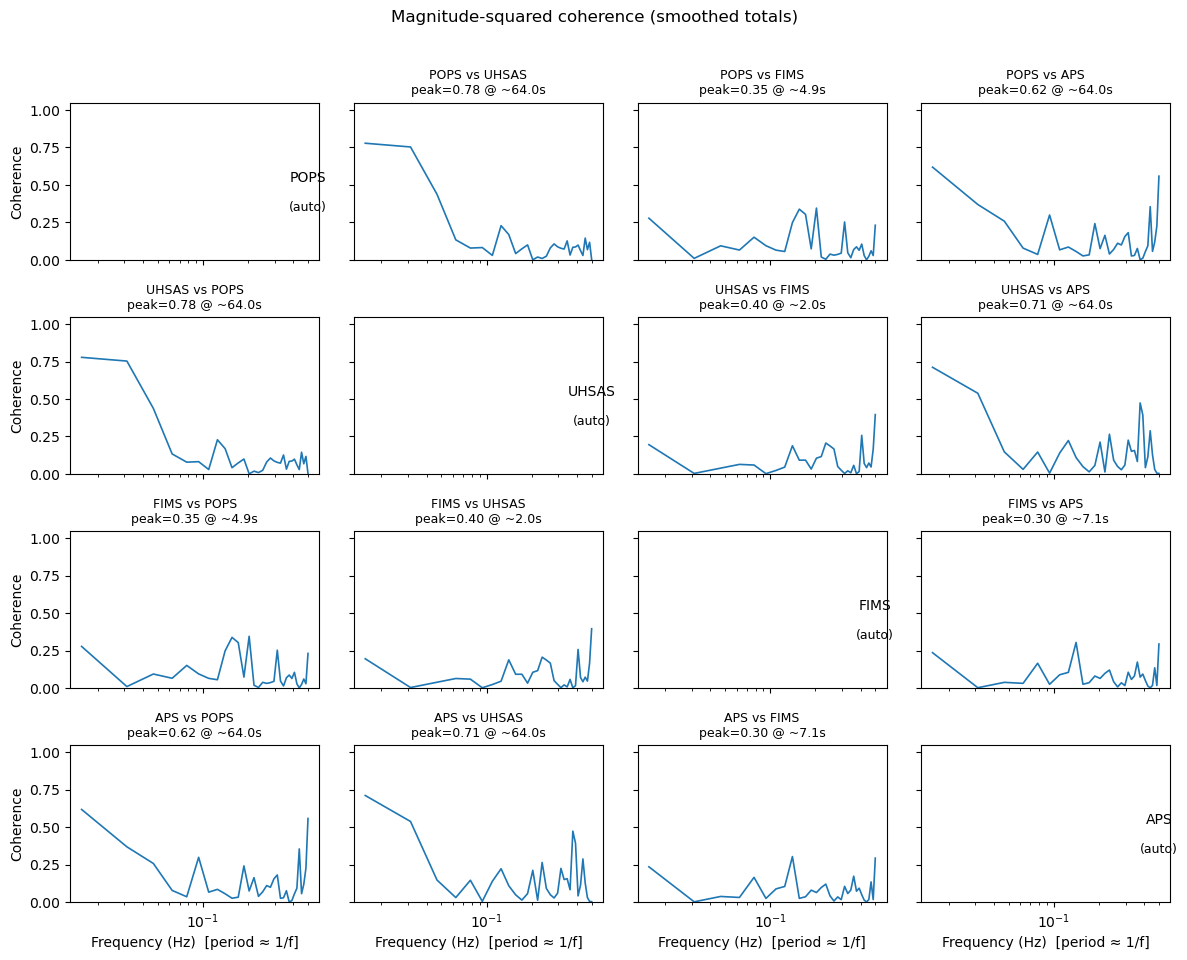

In [35]:
# --- Magnitude-squared coherence among instruments (smoothed totals) ---
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.signal import coherence

print("\n=== Coherence analysis (using smoothed data) ===")

# If smoothed_totals doesn't exist yet, build it (same params as earlier)
try:
    smoothed_totals
except NameError:
    smoothed_totals = {}
    for name, s in totals.items():
        s_gauss = s.rolling(GAUSS_WIN_SAMPLES, win_type="gaussian", min_periods=1, center=True).mean(std=GAUSS_STD_SAMPLES)
        smoothed_totals[name] = s_gauss

# Instruments available
names = ["POPS", "UHSAS", "FIMS", "APS"]
names = [n for n in names if n in smoothed_totals]
k = len(names)
if k < 2:
    raise RuntimeError("Need at least two instruments for coherence.")

# Sampling frequency (Hz) from median dt
idx0 = smoothed_totals[names[0]].index
dt_s = np.median(np.diff(idx0.values).astype("timedelta64[ms]").astype(float)) / 1000.0
fs = 1.0 / dt_s

# Welch parameters: aim for ~8 segments with 50% overlap; keep sane bounds
n_samples = min(len(smoothed_totals[n].dropna()) for n in names)
nperseg = int(2 ** np.floor(np.log2(max(32, min(1024, n_samples // 4)))))  # 32..1024
noverlap = nperseg // 2

def pair_coherence(a, b):
    xa = smoothed_totals[a].to_numpy()
    xb = smoothed_totals[b].to_numpy()
    mask = np.isfinite(xa) & np.isfinite(xb)
    xa = xa[mask]
    xb = xb[mask]
    if len(xa) < max(16, nperseg):
        return None
    f, Cxy = coherence(xa, xb, fs=fs, nperseg=nperseg, noverlap=noverlap, detrend="constant")
    return f, Cxy

# Compute and print summary table
summary = []
for a, b in combinations(names, 2):
    out = pair_coherence(a, b)
    if out is None:
        print(f"{a} vs {b}: not enough overlapping samples for coherence.")
        continue
    f, Cxy = out
    valid = f > 0
    if not np.any(valid):
        print(f"{a} vs {b}: no valid frequency bins.")
        continue
    i_peak = np.argmax(Cxy[valid])
    f_peak = f[valid][i_peak]
    coh_peak = Cxy[valid][i_peak]
    T_peak = 1.0 / f_peak  # seconds

    # band means (optional quick view)
    bands = {
        "fast(<30s)": (f >= 1/30),
        "mid(30–120s)": (f >= 1/120) & (f < 1/30),
        "slow(>120s)": (f > 0) & (f < 1/120),
    }
    band_means = {k: float(np.nanmean(Cxy[v])) if np.any(v) else np.nan for k, v in bands.items()}
    summary.append((a, b, coh_peak, T_peak, band_means))
    print(f"{a} vs {b}: peak coh = {coh_peak:.2f} at period ~ {T_peak:.1f} s | "
          f"bands: fast={band_means['fast(<30s)']:.2f}, mid={band_means['mid(30–120s)']:.2f}, slow={band_means['slow(>120s)']:.2f}")

# --- Plot a k×k coherence matrix (off-diagonal = coherence curves) ---
fig, axes = plt.subplots(k, k, figsize=(3.0*k, 2.4*k), sharex=True, sharey=True)

cache = {}
for i, a in enumerate(names):
    for j, b in enumerate(names):
        if i == j:
            cache[(i, j)] = None
        else:
            cache[(i, j)] = pair_coherence(a, b)

for i, a in enumerate(names):
    for j, b in enumerate(names):
        ax = axes[i, j] if k > 1 else axes
        ax.set_xscale("log")
        ax.set_ylim(0, 1.05)
        if i == j:
            ax.text(0.5, 0.55, a, ha="center", va="center", fontsize=10)
            ax.text(0.5, 0.35, "(auto)", ha="center", va="center", fontsize=9)
        else:
            out = cache[(i, j)]
            if out is None:
                ax.text(0.5, 0.5, "no overlap", ha="center", va="center")
            else:
                f, Cxy = out
                mask = f > 0  # avoid f=0 on log axis
                ax.plot(f[mask], Cxy[mask], linewidth=1.2)
                if np.any(mask):
                    i_peak = np.argmax(Cxy[mask])
                    f_peak = f[mask][i_peak]
                    coh_peak = Cxy[mask][i_peak]
                    T_peak = 1.0 / f_peak
                    ax.set_title(f"{a} vs {b}\npeak={coh_peak:.2f} @ ~{T_peak:.1f}s", fontsize=9)

        if i == k - 1:
            ax.set_xlabel("Frequency (Hz)  [period ≈ 1/f]")
        if j == 0:
            ax.set_ylabel("Coherence")

fig.suptitle("Magnitude-squared coherence (smoothed totals)", y=0.995)
fig.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()